# Exploratory Data Analysis - EDA
This dataset is used to predict risk_level (low or high) based on task characteristics.
#### features
1. **day_since_start**: Number of days the task has been active since its start date.
2. **deadline_day_of_week**: Day of the week on which the task’s deadline falls (Monday–Sunday). Some days may have different completion patterns.
3. **days_until_deadline**: Remaining number of days until the task’s deadline.
4. **estimated_hours**: Planned effort required to complete the task, expressed in hours.
5. **priority**: Priority level of the task (low, medium, high).
6. **has_dependencies**: Indicates whether the task is blocked or dependent on other tasks.
7. **team_size**: Number of team members assigned to the task.
8. **project_overdue_rate**: Proportion of overdue tasks within the project the task belongs to.
9. **assignee_overdue_rate**: Proportion of overdue tasks previously assigned to the same assignee(s).
10. **progress_gap**: Difference between actual progress (completion percentage) and expected progress (based on timeline). Negative values indicate lagging progress.
#### target
11. **risk_level**: risk of delayed task

### Import libraries and load data

In [104]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import calendar
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import joblib
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, log_loss
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import numpy as np

In [105]:
df = pd.read_csv('./task_risk_dataset.csv')

### Summary

In [106]:
print(f"Shape: {df.shape}")
df.info()
df.head()

Shape: (403, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403 entries, 0 to 402
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   day_since_start        403 non-null    int64  
 1   deadline_day_of_week   403 non-null    object 
 2   days_until_deadline    403 non-null    int64  
 3   estimated_hours        403 non-null    float64
 4   priority               403 non-null    object 
 5   has_dependencies       403 non-null    bool   
 6   team_size              403 non-null    int64  
 7   project_overdue_rate   403 non-null    float64
 8   assignee_overdue_rate  403 non-null    float64
 9   progress_gap           403 non-null    float64
 10  risk_level             403 non-null    object 
dtypes: bool(1), float64(4), int64(3), object(3)
memory usage: 32.0+ KB


,day_since_start,deadline_day_of_week,days_until_deadline,estimated_hours,priority,has_dependencies,team_size,project_overdue_rate,assignee_overdue_rate,progress_gap,risk_level
0,21,Wednesday,23,14.5,medium,True,2,0.41,0.59,-2.2,high
1,37,Tuesday,46,3.4,low,False,1,0.17,0.47,11.8,low
2,39,Wednesday,4,23.2,low,False,2,0.37,0.42,-13.2,high
3,39,Thursday,58,7.7,medium,False,1,0.41,0.34,-6.1,low
4,19,Monday,46,27.5,high,True,2,0.22,0.28,10.7,low


In [107]:
print(f"target value distribution:\n{df['risk_level'].value_counts()}")

target value distribution:
risk_level
low     211
high    192
Name: count, dtype: int64


In [108]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
day_since_start,403.0,NaN,NaN,NaN,38.173697,28.570583,0.0,16.0,32.0,53.5,149.0
deadline_day_of_week,403,5,Wednesday,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN
days_until_deadline,403.0,NaN,NaN,NaN,31.191067,20.402437,0.0,16.5,28.0,44.0,101.0
estimated_hours,403.0,NaN,NaN,NaN,28.25335,20.911386,2.0,13.6,23.5,37.45,119.0
priority,403,3,medium,137,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_dependencies,403,2,True,217,NaN,NaN,NaN,NaN,NaN,NaN,NaN
team_size,403.0,NaN,NaN,NaN,2.647643,1.277401,1.0,2.0,2.0,3.0,7.0
project_overdue_rate,403.0,NaN,NaN,NaN,0.240174,0.119606,0.04,0.15,0.22,0.33,0.59
assignee_overdue_rate,403.0,NaN,NaN,NaN,0.320422,0.130596,0.06,0.215,0.31,0.42,0.67
progress_gap,403.0,NaN,NaN,NaN,-7.319851,15.979861,-58.7,-17.6,-7.5,3.8,25.0


### Handling missing values

In [109]:
print(df.isnull().sum())

day_since_start          0
deadline_day_of_week     0
days_until_deadline      0
estimated_hours          0
priority                 0
has_dependencies         0
team_size                0
project_overdue_rate     0
assignee_overdue_rate    0
progress_gap             0
risk_level               0
dtype: int64


### Handling Categorical Variables

In [110]:
category_columns = df.select_dtypes(include=['object', 'bool']).columns.tolist()
for c in category_columns:
    print(df[c].value_counts(), end="\n================================\n")

deadline_day_of_week
Wednesday    96
Tuesday      83
Monday       77
Thursday     74
Friday       73
Name: count, dtype: int64
priority
medium    137
high      135
low       131
Name: count, dtype: int64
has_dependencies
True     217
False    186
Name: count, dtype: int64
risk_level
low     211
high    192
Name: count, dtype: int64


In [111]:
labelEncoder = LabelEncoder()
encoded_df = df.copy()
encoded_df['has_dependencies'] = labelEncoder.fit_transform(df['has_dependencies'])

dow_ordinal_encoder = OrdinalEncoder(categories=[list(calendar.day_name)])
encoded_df['deadline_day_of_week'] = dow_ordinal_encoder.fit_transform(df[['deadline_day_of_week']])

priority_ordinal_encoder = OrdinalEncoder(categories=[['low', 'medium', 'high']])
encoded_df['priority'] = priority_ordinal_encoder.fit_transform(df[['priority']])

encoded_df['risk_level'] = df['risk_level'].map({'low': 0, 'high': 1})

encoded_df.head()

,day_since_start,deadline_day_of_week,days_until_deadline,estimated_hours,priority,has_dependencies,team_size,project_overdue_rate,assignee_overdue_rate,progress_gap,risk_level
0,21,2.0,23,14.5,1.0,1,2,0.41,0.59,-2.2,1
1,37,1.0,46,3.4,0.0,0,1,0.17,0.47,11.8,0
2,39,2.0,4,23.2,0.0,0,2,0.37,0.42,-13.2,1
3,39,3.0,58,7.7,1.0,0,1,0.41,0.34,-6.1,0
4,19,0.0,46,27.5,2.0,1,2,0.22,0.28,10.7,0


In [112]:
for c in category_columns:
    print(encoded_df[c].value_counts(), end="\n================================\n")

deadline_day_of_week
2.0    96
1.0    83
0.0    77
3.0    74
4.0    73
Name: count, dtype: int64
priority
1.0    137
2.0    135
0.0    131
Name: count, dtype: int64
has_dependencies
1    217
0    186
Name: count, dtype: int64
risk_level
0    211
1    192
Name: count, dtype: int64


### Handling outliers

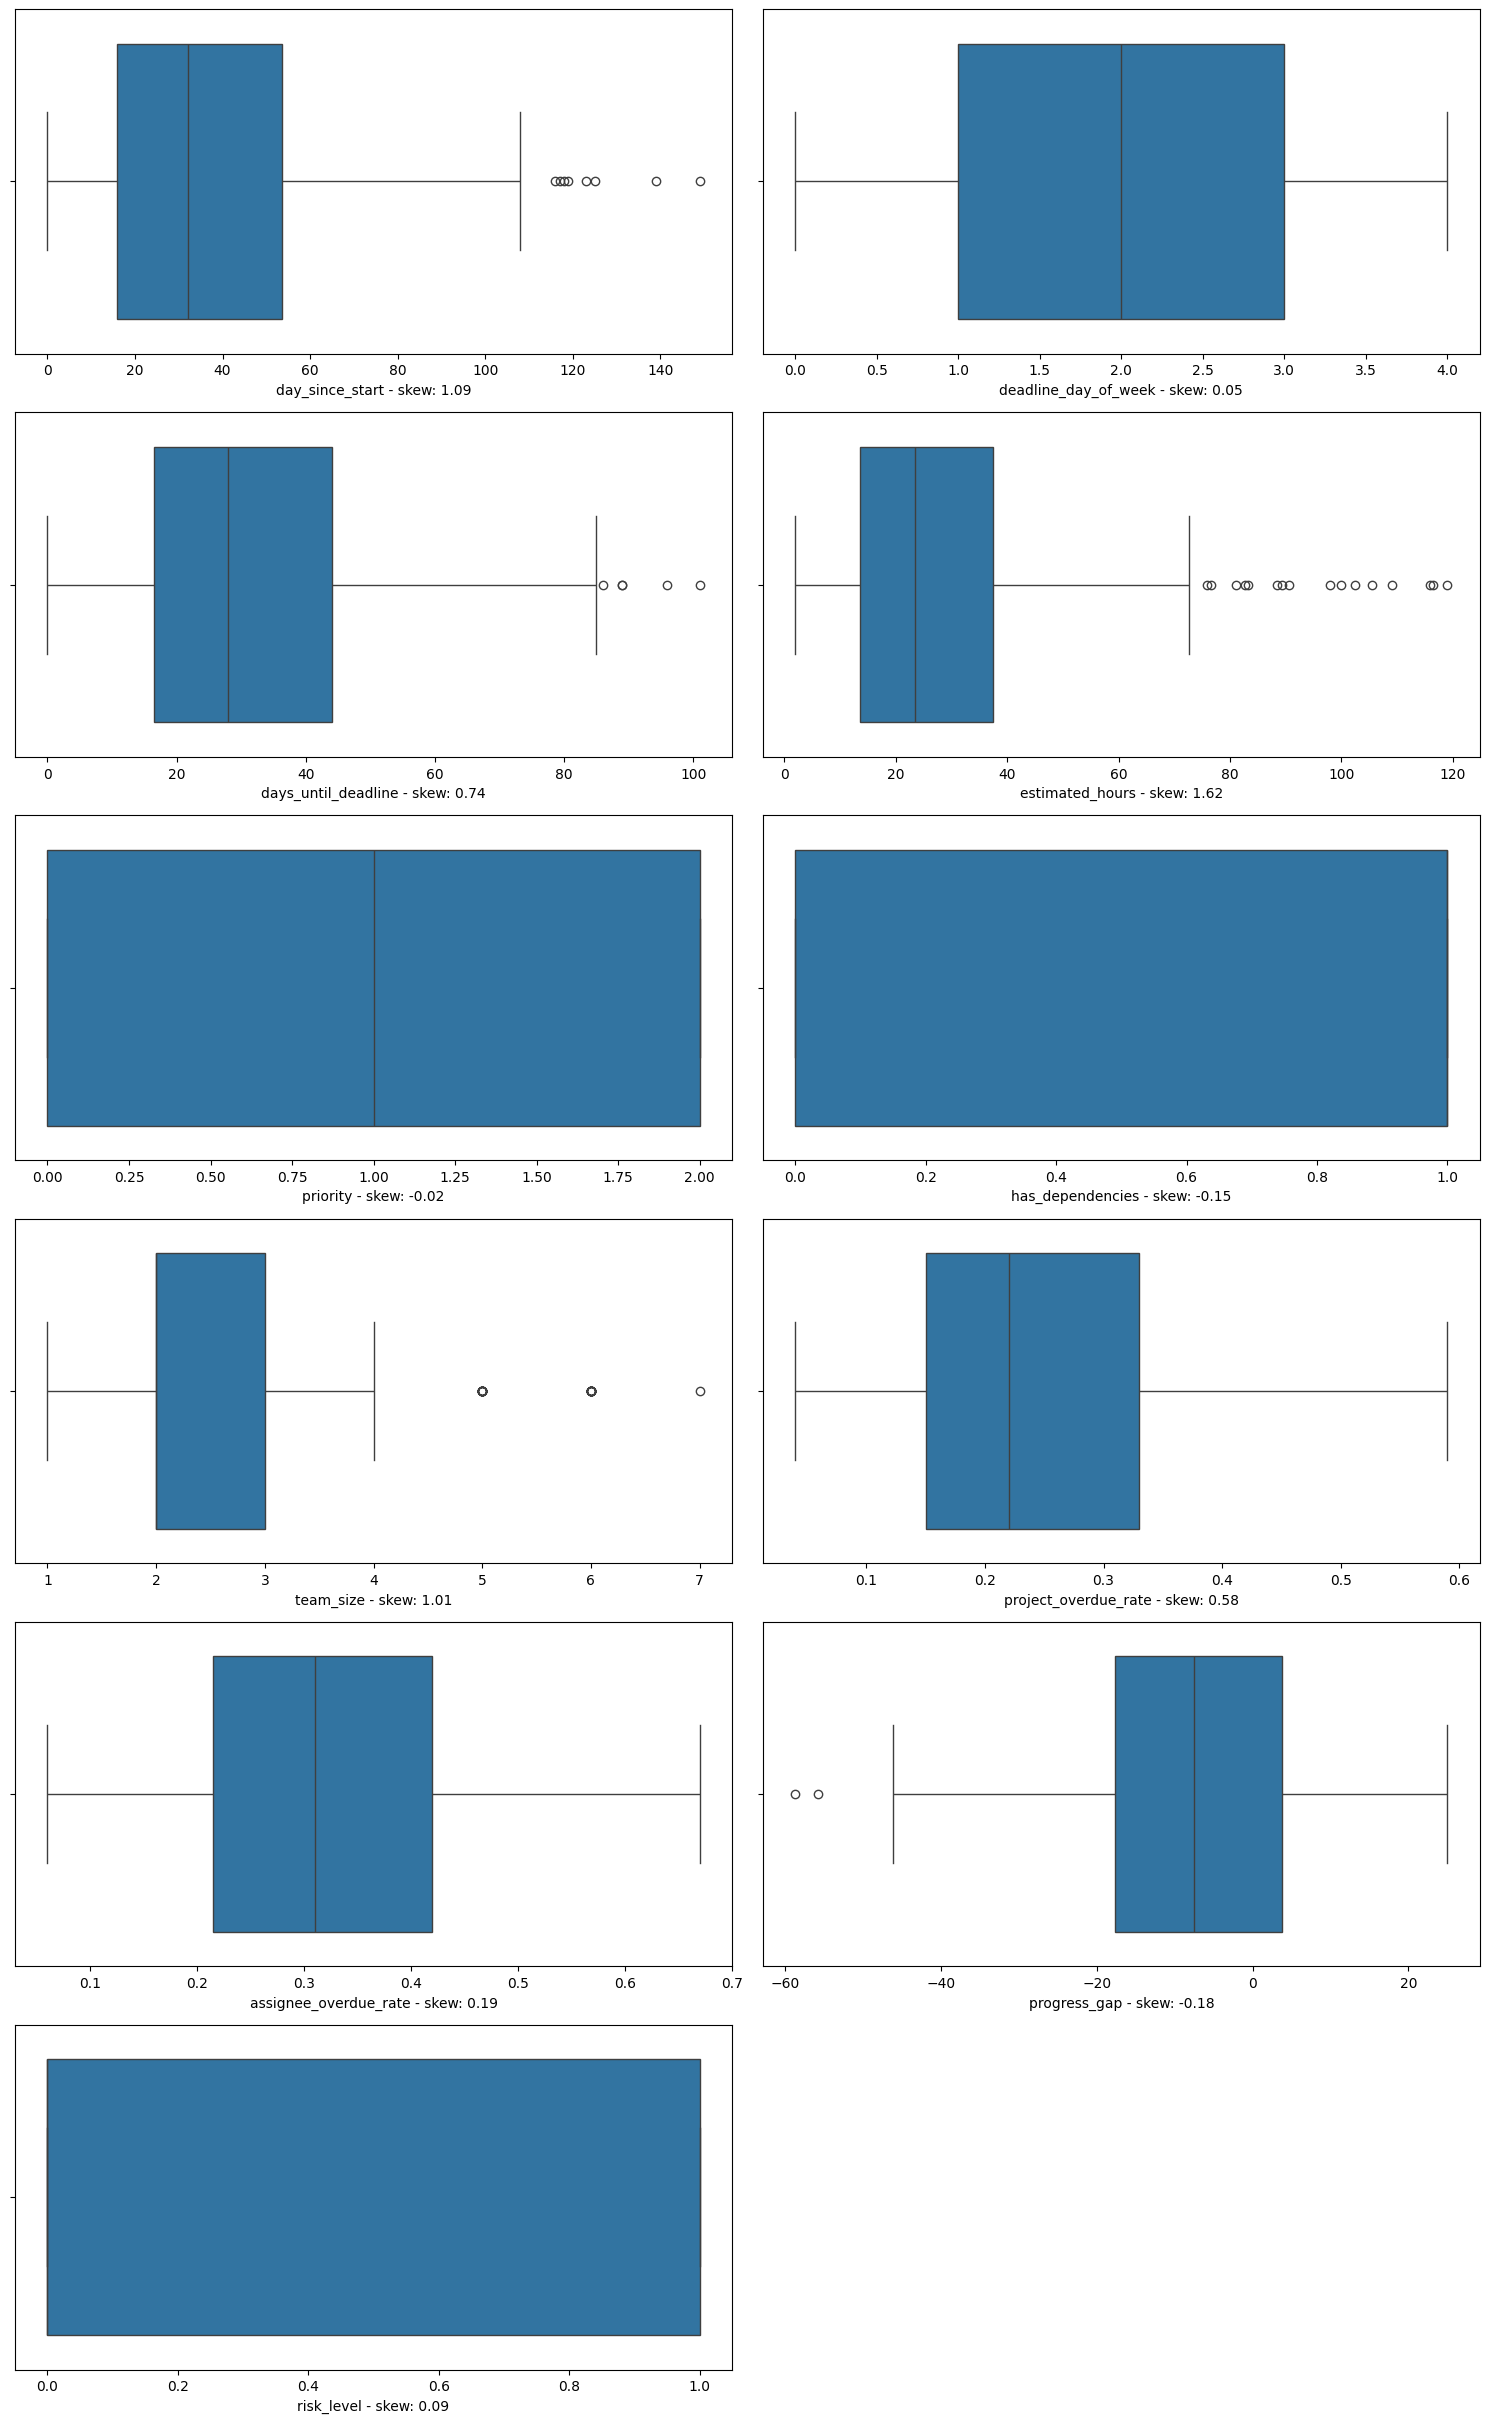

In [113]:
fig, axes = plt.subplots(9, 2, figsize=(15, 36))

axes = axes.flatten()

for i, col in enumerate(encoded_df.columns):
    sns.boxplot(x=encoded_df[col], ax=axes[i])
    axes[i].set_xlabel(f'{col} - skew: {round(encoded_df[col].skew(), 2)}')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Bivariate analysis

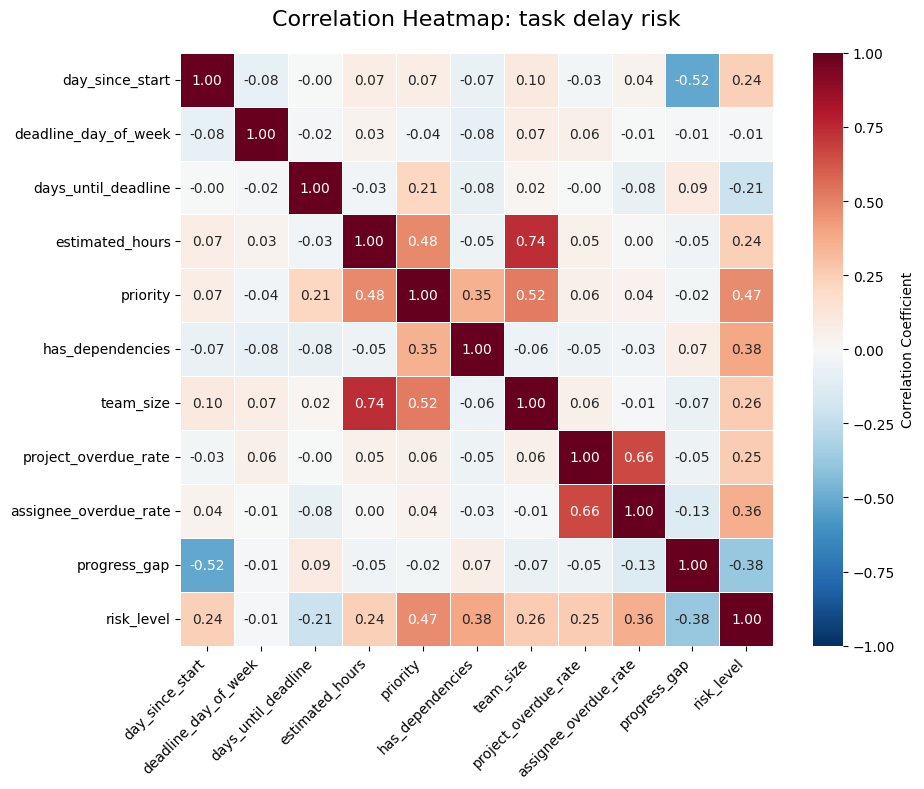

In [114]:
plt.figure(figsize=(10, 8))  # Set figure size to match the example
sns.heatmap(encoded_df.corr(), 
            annot=True,            # Show correlation values in cells
            cmap='RdBu_r',         # Red-Blue reversed (red for positive, blue for negative)
            fmt='.2f',             # Format to 2 decimal places
            square=True,           # Make cells square
            linewidths=0.5,        # Add lines between cells
            cbar_kws={'label': 'Correlation Coefficient', 'shrink': 1},  # Customize color bar
            vmin=-1, vmax=1)       # Set the range of the color scale

plt.title('Correlation Heatmap: task delay risk', fontsize=16, pad=20)  # Match the title
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.yticks(rotation=0)               # Keep y-axis labels horizontal
plt.tight_layout()                   # Adjust layout

# Step 5: Display the heatmap
plt.show()

### Train-test Split

In [115]:
encoded_target_df = df.copy()
encoded_target_df['risk_level'] = df['risk_level'].map({'low': 0, 'high': 1})
X = encoded_target_df.iloc[:, :-1]
y = encoded_target_df['risk_level']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(y_train.value_counts())
print(y_test.value_counts())

risk_level
0    169
1    153
Name: count, dtype: int64
risk_level
0    42
1    39
Name: count, dtype: int64


### Feature scaling and normalization

In [116]:
features_to_scale = [
    'day_since_start', 
    'days_until_deadline', 
    'estimated_hours', 
    'team_size', 
    'project_overdue_rate', 
    'assignee_overdue_rate', 
    'progress_gap',
]

preprocessor = ColumnTransformer(
    transformers=[
        ('has_deps_enc', OrdinalEncoder(), ['has_dependencies']),
        
        ('dow_ordinal_enc', 
         OrdinalEncoder(categories=[list(calendar.day_name)]), 
         ['deadline_day_of_week']),
        
        ('priority_ordinal_enc', 
         OrdinalEncoder(categories=[['low', 'medium', 'high']]), 
         ['priority']),
        
        ('robust_scale', RobustScaler(), features_to_scale)
    ],
    remainder='passthrough'
)


### XGBoost
XGBoost = many small decision trees, each decision tree fixes error of previous decision tree

In [117]:
xgb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42))
])
xgb_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('has_deps_enc', ...), ('dow_ordinal_enc', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Random forest
RF uses many small decision trees, each decision tree looks at different random parts of the data, results are combined by voting (majority voting)

In [118]:
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('has_deps_enc', ...), ('dow_ordinal_enc', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Logistic Regression
Uses sigmoid function

In [119]:
lr_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])
lr_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('has_deps_enc', ...), ('dow_ordinal_enc', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Support vector machine
It tries to find the best boundary known as hyperplane that separates different classes in the data

In [120]:
svm_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        probability=True,
        random_state=42
    ))
])
svm_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('has_deps_enc', ...), ('dow_ordinal_enc', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Decision tree

In [121]:
dt_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
dt_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('has_deps_enc', ...), ('dow_ordinal_enc', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluation

#### Cross-validation evaluation

In [131]:
print("--- Cross-Validation (CV) Score ---")
print("\nXGBoost")
cv_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1)
mean_cv_log_loss = -np.mean(cv_scores)
std_cv_log_loss = np.std(cv_scores)
print(f"Mean Cross-Validated Log Loss: {mean_cv_log_loss:.4f} (+/- {std_cv_log_loss:.4f})")

print("\nRandom forest")
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1)
mean_cv_log_loss = -np.mean(cv_scores)
std_cv_log_loss = np.std(cv_scores)
print(f"Mean Cross-Validated Log Loss: {mean_cv_log_loss:.4f} (+/- {std_cv_log_loss:.4f})")

print("\nLogistic Regression")
cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1)
mean_cv_log_loss = -np.mean(cv_scores)
std_cv_log_loss = np.std(cv_scores)
print(f"Mean Cross-Validated Log Loss: {mean_cv_log_loss:.4f} (+/- {std_cv_log_loss:.4f})")

print("\nSupport Vector Machine")
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1)
mean_cv_log_loss = -np.mean(cv_scores)
std_cv_log_loss = np.std(cv_scores)
print(f"Mean Cross-Validated Log Loss: {mean_cv_log_loss:.4f} (+/- {std_cv_log_loss:.4f})")

print("\nDecision Tree")
cv_scores = cross_val_score(dt_model, X_train, y_train, cv=5, scoring='neg_log_loss', n_jobs=-1)
mean_cv_log_loss = -np.mean(cv_scores)
std_cv_log_loss = np.std(cv_scores)
print(f"Mean Cross-Validated Log Loss: {mean_cv_log_loss:.4f} (+/- {std_cv_log_loss:.4f})")

--- Cross-Validation (CV) Score ---

XGBoost
Mean Cross-Validated Log Loss: 0.3552 (+/- 0.0638)

Random forest
Mean Cross-Validated Log Loss: 0.3765 (+/- 0.0465)

Logistic Regression
Mean Cross-Validated Log Loss: 0.2787 (+/- 0.0696)

Support Vector Machine
Mean Cross-Validated Log Loss: 0.3014 (+/- 0.0802)

Decision Tree
Mean Cross-Validated Log Loss: 0.6321 (+/- 0.1782)


#### Final Test Set Evaluation

In [130]:
print("XGBoost================================")
y_pred = xgb_model.predict(X_test)
y_score = xgb_model.predict_proba(X_test)[:, 1]
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAUC score:")
print(roc_auc_score(y_test, y_score))
print("Log loss:")
print(log_loss(y_test, y_score))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Random forest================================")
y_pred = rf_model.predict(X_test)
y_score = rf_model.predict_proba(X_test)[:, 1]
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAUC score:")
print(roc_auc_score(y_test, y_score))
print("Log loss:")
print(log_loss(y_test, y_score))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Logistic Regression================================")
y_pred = lr_model.predict(X_test)
y_score = lr_model.predict_proba(X_test)[:, 1]
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAUC score:")
print(roc_auc_score(y_test, y_score))
print("Log loss:")
print(log_loss(y_test, y_score))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Support Vector Machine================================")
y_pred = svm_model.predict(X_test)
y_score = svm_model.predict_proba(X_test)[:, 1]
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAUC score:")
print(roc_auc_score(y_test, y_score))
print("Log loss:")
print(log_loss(y_test, y_score))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Decision Tree================================")
y_pred = dt_model.predict(X_test)
y_score = dt_model.predict_proba(X_test)[:, 1]
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nAUC score:")
print(roc_auc_score(y_test, y_score))
print("Log loss:")
print(log_loss(y_test, y_score))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

XGBoost================================
Confusion Matrix:
[[36  6]
 [ 3 36]]

AUC score:
0.946886446886447
Log loss:
0.3193166245771514

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        42
           1       0.86      0.92      0.89        39

    accuracy                           0.89        81
   macro avg       0.89      0.89      0.89        81
weighted avg       0.89      0.89      0.89        81

Random forest================================
Confusion Matrix:
[[36  6]
 [ 5 34]]

AUC score:
0.9603174603174603
Log loss:
0.36059935901535717

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87        42
           1       0.85      0.87      0.86        39

    accuracy                           0.86        81
   macro avg       0.86      0.86      0.86        81
weighted avg       0.86      0.86      0.86        81

Logistic Regressio

### Hyperparameter optimization

In [124]:
# Note: Hyperparameters in a Pipeline are prefixed with the step name and two underscores.
param_grid_xgb = {
    'classifier__max_depth': [3, 6], # Depth of each tree
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'classifier__n_estimators': range(300, 600, 50) # Number of trees
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='neg_log_loss',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("Starting Grid Search for XGBoost Hyperparameter Optimization...")
grid_search_xgb.fit(X_train, y_train)

print("\n--- XGBoost Grid Search Results ---")
print(f"Best Log Loss Score: {-grid_search_xgb.best_score_:.4f}")
print(f"Best Hyperparameters: {grid_search_xgb.best_params_}")

xgb_model = grid_search_xgb.best_estimator_

Starting Grid Search for XGBoost Hyperparameter Optimization...
Fitting 5 folds for each of 60 candidates, totalling 300 fits

--- XGBoost Grid Search Results ---
Best Log Loss Score: 0.3552
Best Hyperparameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 550}


In [125]:
param_grid_rf = {
    'classifier__n_estimators': [100, 300, 500], # Number of trees in the forest
    'classifier__max_depth': [None, 10, 20, 30], # Maximum tree depth
    'classifier__min_samples_split': [2, 5, 10], # Minimum samples to split node
    'classifier__min_samples_leaf': [1, 3, 4], # Minimum samples in leaf
    'classifier__max_features': ['sqrt', 'log2'], # Number of features to consider
}

grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring='neg_log_loss',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("\nStarting Grid Search for Random Forest Hyperparameter Optimization...")
grid_search_rf.fit(X_train, y_train)

print("\n--- Random Forest Grid Search Results ---")
print(f"Best Log Loss Score: {-grid_search_rf.best_score_:.4f}")
print(f"Best Hyperparameters: {grid_search_rf.best_params_}")

rf_model = grid_search_rf.best_estimator_


Starting Grid Search for Random Forest Hyperparameter Optimization...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

--- Random Forest Grid Search Results ---
Best Log Loss Score: 0.3765
Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 300}


In [126]:
param_grid_lr = [
    # L2 Penalty (default) - works with all solvers
    {
        'classifier__penalty': ['l2'],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__solver': ['lbfgs', 'saga'],
        'classifier__max_iter': [200, 500]
    },
    # L1 Penalty (Lasso) - for feature selection
    {
        'classifier__penalty': ['l1'],
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Added 0.001
        'classifier__solver': ['liblinear', 'saga'],  # Correct!
        'classifier__max_iter': [200, 500]
    },
]

grid_search_lr = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid_lr,
    scoring='neg_log_loss',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("\nStarting Grid Search for Logistic Regression Hyperparameter Optimization...")
grid_search_lr.fit(X_train, y_train)

print("\n--- Logistic Regression Grid Search Results ---")
print(f"Best Log Loss Score: {-grid_search_lr.best_score_:.4f}")
print(f"Best Hyperparameters: {grid_search_lr.best_params_}")

lr_model = grid_search_lr.best_estimator_


Starting Grid Search for Logistic Regression Hyperparameter Optimization...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

--- Logistic Regression Grid Search Results ---
Best Log Loss Score: 0.2787
Best Hyperparameters: {'classifier__C': 10, 'classifier__max_iter': 200, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


In [127]:
param_grid_svm = {
    'classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'classifier__C': [0.01, 0.1, 1, 10]
}

grid_search_svm = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid_svm,
    scoring='neg_log_loss',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("\nStarting Grid Search for SVC Hyperparameter Optimization...")
grid_search_svm.fit(X_train, y_train)

print("\n--- SVC Grid Search Results ---")
print(f"Best Log Loss Score: {-grid_search_svm.best_score_:.4f}")
print(f"Best Hyperparameters: {grid_search_svm.best_params_}")

svm_model = grid_search_svm.best_estimator_


Starting Grid Search for SVC Hyperparameter Optimization...
Fitting 5 folds for each of 16 candidates, totalling 80 fits

--- SVC Grid Search Results ---
Best Log Loss Score: 0.3014
Best Hyperparameters: {'classifier__C': 10, 'classifier__kernel': 'linear'}


In [128]:
param_grid_dt = {
    'classifier__max_depth': [3, 5, 7, 9, None],
    'classifier__min_samples_split': [10, 20, 40], # Minimum samples to split node
    'classifier__min_samples_leaf': [5, 10, 15], # Minimum samples in leaf
    'classifier__max_features': ['sqrt', 'log2', None]
}

grid_search_dt = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid_dt,
    scoring='neg_log_loss',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("Starting Grid Search for Decision Tree Hyperparameter Optimization...")
grid_search_dt.fit(X_train, y_train)

print("\n--- Grid Search Results ---")
print(f"Best Log Loss Score: {-grid_search_dt.best_score_:.4f}")
print(f"Best Hyperparameters: {grid_search_dt.best_params_}")

dt_model = grid_search_dt.best_estimator_

Starting Grid Search for Decision Tree Hyperparameter Optimization...
Fitting 5 folds for each of 135 candidates, totalling 675 fits

--- Grid Search Results ---
Best Log Loss Score: 0.6321
Best Hyperparameters: {'classifier__max_depth': 3, 'classifier__max_features': None, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 10}


### Save model

In [132]:
joblib.dump(xgb_model, "best_xgb_model.joblib")
joblib.dump(rf_model, "best_rf_model.joblib")
joblib.dump(lr_model, "best_lr_model.joblib")
joblib.dump(svm_model, "best_svm_model.joblib")
joblib.dump(dt_model, "best_dt_model.joblib")

['best_dt_model.joblib']